# **Dimensionality Reduction + Clustering**

### **Imports**

In [103]:
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import DBSCAN, KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import calinski_harabasz_score, davies_bouldin_score, silhouette_score
import matplotlib.pyplot as plt

### **Loading and Preprocessing WINE dataset**

In [91]:
# Import datasets
from sklearn.datasets import load_iris
from sklearn.datasets import load_wine

# Load dataset
def load_and_prepare_data():
    wine = load_wine()
    data = pd.DataFrame(wine.data, columns=wine.feature_names)
    data['target'] = wine.target
    return data

data = load_and_prepare_data()
print(data.head())

   alcohol  malic_acid   ash  alcalinity_of_ash  magnesium  total_phenols  \
0    14.23        1.71  2.43               15.6      127.0           2.80   
1    13.20        1.78  2.14               11.2      100.0           2.65   
2    13.16        2.36  2.67               18.6      101.0           2.80   
3    14.37        1.95  2.50               16.8      113.0           3.85   
4    13.24        2.59  2.87               21.0      118.0           2.80   

   flavanoids  nonflavanoid_phenols  proanthocyanins  color_intensity   hue  \
0        3.06                  0.28             2.29             5.64  1.04   
1        2.76                  0.26             1.28             4.38  1.05   
2        3.24                  0.30             2.81             5.68  1.03   
3        3.49                  0.24             2.18             7.80  0.86   
4        2.69                  0.39             1.82             4.32  1.04   

   od280/od315_of_diluted_wines  proline  target  
0          

In [92]:
def preprocess_data(data):
    # Separate features and labels
    features = data.drop(columns=['target'])
    scaler = StandardScaler()
    scaled_features = scaler.fit_transform(features)
    return scaled_features

# Preprocess the data
scaled_data = preprocess_data(data)


### **Tuning T-sne for best performance**
I had previous issues with t-sne not labeling clusters properly and as a result I decided tuning it for best results would be preferable to trying to hardcode whatever magical numbers in the hopes it works

In [93]:
def tune_tsne_and_dbscan(
        scaled_data,
        perplexities=[5, 30, 50],
        iterations=[500, 5000],
        eps_values=[0.3, 0.5, 0.7],
        min_samples_values=[3, 5]
):
    best_score = -1
    best_params = None
    results = []

    for p in perplexities:
        for it in iterations:
            # Apply t-SNE with the current perplexity & iteration settings
            tsne = TSNE(n_components=2, perplexity=p, max_iter=it, random_state=42)
            tsne_data = tsne.fit_transform(scaled_data)

            for eps in eps_values:
                for ms in min_samples_values:
                    # Apply DBSCAN on the t-SNE output
                    dbscan = DBSCAN(eps=eps, min_samples=ms)
                    labels = dbscan.fit_predict(tsne_data)

                    # Only compute Silhouette if there's more than one cluster
                    # and not *everything* is labeled as outlier (-1)
                    unique_labels = set(labels)
                    if len(unique_labels) > 1 and -1 in unique_labels and len(unique_labels) > 2:
                        pass
                    if len(unique_labels) > 1:
                        score = silhouette_score(tsne_data, labels)
                        results.append((p, it, eps, ms, score))

                        # Track if this is the best so far
                        if score > best_score:
                            best_score = score
                            best_params = (p, it, eps, ms)

    return best_score, best_params, results


best_score, best_params, all_results = tune_tsne_and_dbscan(scaled_data)

print("Best Silhouette Score:", best_score)
print("Best Parameter Combination (perplexity, n_iter, eps, min_samples):", best_params)
print("All results:", all_results)

Best Silhouette Score: 0.36542785
Best Parameter Combination (perplexity, n_iter, eps, min_samples): (50, 5000, 0.7, 5)
All results: [(30, 500, 0.3, 3, np.float32(0.008956191)), (30, 500, 0.5, 3, np.float32(-0.4580919)), (30, 500, 0.7, 3, np.float32(-0.18911852)), (30, 500, 0.7, 5, np.float32(0.046231247)), (30, 5000, 0.3, 3, np.float32(0.0023872934)), (30, 5000, 0.5, 3, np.float32(-0.45967275)), (30, 5000, 0.7, 3, np.float32(-0.24409118)), (30, 5000, 0.7, 5, np.float32(0.045682434)), (50, 500, 0.3, 3, np.float32(-0.3603185)), (50, 500, 0.5, 3, np.float32(0.0061372933)), (50, 500, 0.5, 5, np.float32(-0.31676936)), (50, 500, 0.7, 3, np.float32(0.22922732)), (50, 500, 0.7, 5, np.float32(0.35692242)), (50, 5000, 0.3, 3, np.float32(-0.35977575)), (50, 5000, 0.5, 3, np.float32(0.00029413888)), (50, 5000, 0.5, 5, np.float32(-0.31607723)), (50, 5000, 0.7, 3, np.float32(0.22989899)), (50, 5000, 0.7, 5, np.float32(0.36542785))]


## **Dimensionality Reduction**

In [94]:
def apply_dimensionality_reduction(scaled_data, method='PCA', n_components=2, **kwargs):
    if method == 'PCA':
        reducer = PCA(n_components=n_components)
    elif method == 't-SNE':
        reducer = TSNE(n_components=n_components, **kwargs)
    else:
        raise ValueError("Method must be 'PCA' or 't-SNE'")
    reduced_data = reducer.fit_transform(scaled_data)
    return reduced_data

# Apply t-SNE using the best params from the tuner:
if best_params:
    p, it, eps, ms = best_params
    tsne_data_optimized = apply_dimensionality_reduction(
        scaled_data,
        method='t-SNE',
        n_components=2,
        perplexity=p,
        max_iter=it,
        random_state=42
    )
else:
    # If something went wrong for God knows what reason, fallback
    tsne_data_optimized = apply_dimensionality_reduction(
        scaled_data,
        method='t-SNE',
        n_components=2,
        perplexity=30,
        max_iter=1000,
        random_state=42
    )

# Apply PCA normally beacuse unlike t-SNE it works
pca_data = apply_dimensionality_reduction(scaled_data, method='PCA')

## **Applying DBSCAN**

In [95]:
def apply_dbscan(data, eps=0.5, min_samples=5):
    dbscan = DBSCAN(eps=eps, min_samples=min_samples)
    labels = dbscan.fit_predict(data)
    return labels

# Apply DBSCAN to raw and pca data
dbscan_labels_raw = apply_dbscan(scaled_data)
dbscan_labels_pca = apply_dbscan(pca_data)
# Apply DBSCAN to tsne
if best_params:
    p, it, eps, ms = best_params
    labels_optimized = apply_dbscan(tsne_data_optimized, eps=eps, min_samples=ms)
else:
    labels_optimized = apply_dbscan(tsne_data_optimized, eps=0.5, min_samples=5)

## **Applying KMeans**

In [96]:
def apply_kmeans(data, n_clusters=3):
    """
    Applies KMeans clustering to the input data with a specified number of clusters.
    Returns the cluster labels.
    """
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    labels = kmeans.fit_predict(data)
    return labels

# Running KMeans on raw, pca, and tsne data
kmeans_labels_raw = apply_kmeans(scaled_data, n_clusters=3)
kmeans_labels_pca = apply_kmeans(pca_data, n_clusters=3)
kmeans_labels_tsne = apply_kmeans(tsne_data_optimized, n_clusters=3)

# ***PLOTTING***

In [115]:
def plot_clustering_results(data, labels, title):
    plt.figure(figsize=(8, 6))
    plt.scatter(data[:, 0], data[:, 1], c=labels, cmap='viridis', s=50, alpha=0.7)
    plt.title(title)
    plt.xlabel('Component 1')
    plt.ylabel('Component 2')
    plt.colorbar(label='Cluster Label')
    plt.show()

## **Plotting DBSCAN Results**

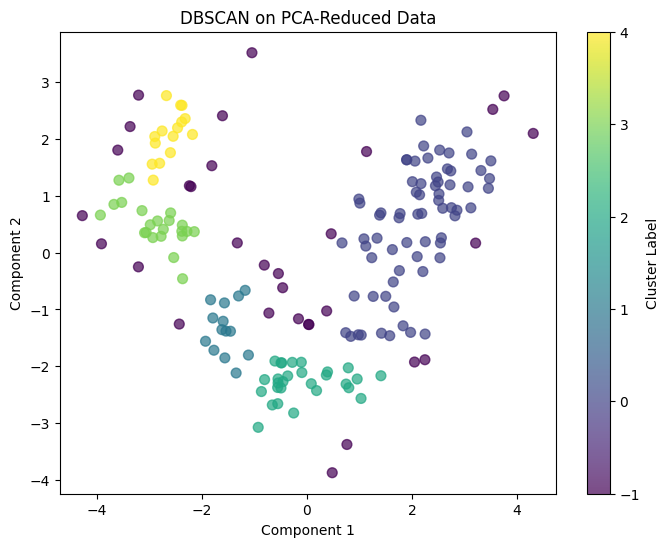

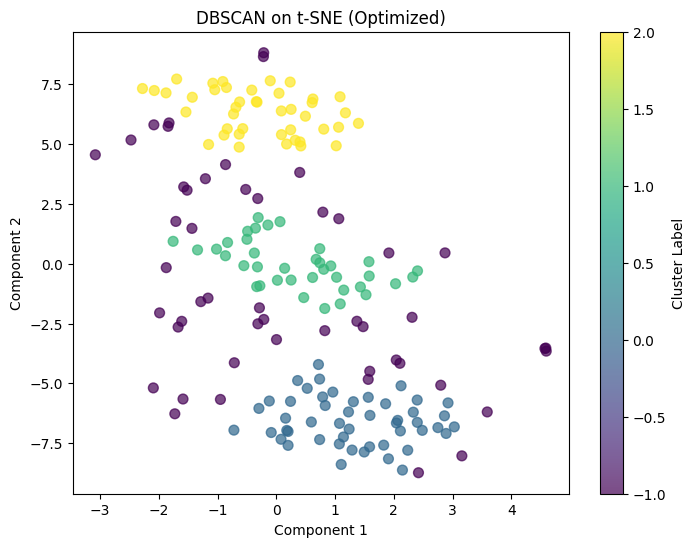

In [116]:
# Visualise results for DBSCAN
plot_clustering_results(pca_data, dbscan_labels_pca, "DBSCAN on PCA-Reduced Data")
plot_clustering_results(tsne_data_optimized, labels_optimized, "DBSCAN on t-SNE (Optimized)")

## **Plotting KMeans Results**

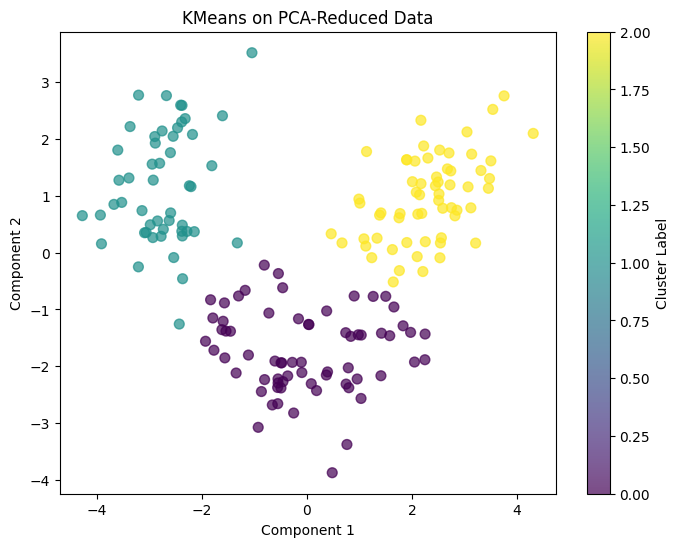

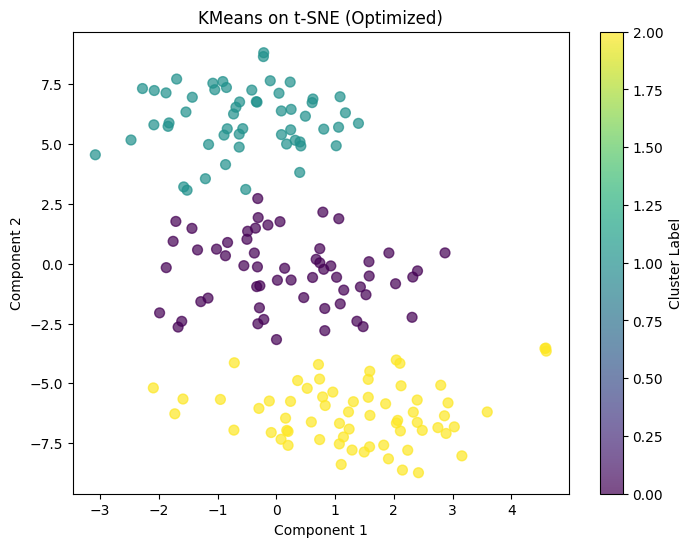

In [117]:
# Visualise results for KMeans
plot_clustering_results(pca_data, kmeans_labels_pca, "KMeans on PCA-Reduced Data")
plot_clustering_results(tsne_data_optimized, kmeans_labels_tsne, "KMeans on t-SNE (Optimized)")

## **Plotting DBSCAN with highlighted outliers**

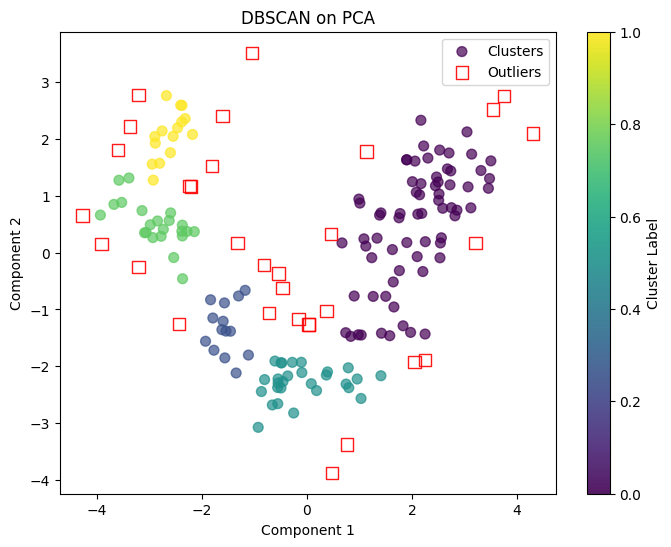

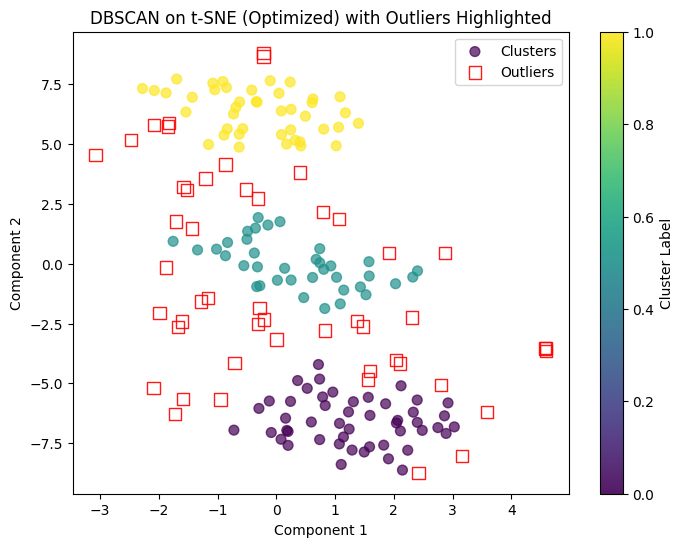

In [98]:
def plot_dbscan_results_with_outliers(data, labels, title):
    """
    Similar to plot_clustering_results, but outliers (label = -1) are shown in red squares.
    """
    plt.figure(figsize=(8,6))

    # Identify outliers
    outlier_mask = (labels == -1)
    cluster_mask = ~outlier_mask

    # Plot non-outliers
    plt.scatter(
        data[cluster_mask, 0],
        data[cluster_mask, 1],
        c=labels[cluster_mask],
        cmap='viridis',
        s=50,
        alpha=0.7,
        label='Clusters'
    )

    # Plot outliers in red squares
    plt.scatter(
        data[outlier_mask, 0],
        data[outlier_mask, 1],
        facecolors='none',
        edgecolors='red',
        s=80,
        alpha=0.9,
        marker='s',
        label='Outliers'
    )

    plt.title(title)
    plt.xlabel('Component 1')
    plt.ylabel('Component 2')
    plt.colorbar(label='Cluster Label')
    plt.legend()
    plt.show()

# Visualize rezults for DBSCAN with highlighted outliers
plot_dbscan_results_with_outliers(pca_data, dbscan_labels_pca, "DBSCAN on PCA")
plot_dbscan_results_with_outliers(tsne_data_optimized, labels_optimized, "DBSCAN on t-SNE (Optimized) with Outliers Highlighted")

# ***EVALUATION***

## **Silhouettes Scores**

In [105]:
def evaluate_clustering(data, labels):
    if len(set(labels)) > 1:
        score = silhouette_score(data, labels)
        return score
    else:
        return "Silhouette Score not defined for single cluster"

# Evaluate the DBSCAN clustering performance
raw_score = evaluate_clustering(scaled_data, dbscan_labels_raw)
pca_score = evaluate_clustering(pca_data, dbscan_labels_pca)
tsne_score_optimized = evaluate_clustering(tsne_data_optimized, labels_optimized)

# Evaluate the KMeans clustering performance
kmeans_raw_score = evaluate_clustering(scaled_data, kmeans_labels_raw)
kmeans_pca_score = evaluate_clustering(pca_data, kmeans_labels_pca)
kmeans_tsne_score = evaluate_clustering(tsne_data_optimized, kmeans_labels_tsne)

print("Silhouette Scores:\n")

print("\nDBSCAN Silhouette Scores:")
print("Raw DBSCAN Score:", raw_score)
print(f"PCA-Reduced Data: {pca_score}")
print(f"t-SNE-Reduced Data: {tsne_score_optimized}")

print("\nKMeans Silhouette Scores:")
print("Raw KMEANS Score:", kmeans_raw_score)
print("PCA:", kmeans_pca_score)
print("t-SNE (Optimized):", kmeans_tsne_score)


Silhouette Scores:


DBSCAN Silhouette Scores:
Raw DBSCAN Score: Silhouette Score not defined for single cluster
PCA-Reduced Data: 0.32303613524396435
t-SNE-Reduced Data: 0.3654278516769409

KMeans Silhouette Scores:
Raw KMEANS Score: 0.2848589191898987
PCA: 0.5601697480957202
t-SNE (Optimized): 0.59647703


## **Additional Metrics**
Also evaluating clustering with Calinski-Harabasz & Davies-Bouldin

I know these evaluate stuff but I have no idea how or why. I'm tossing them in anyway

In [101]:
def evaluate_clustering_additional_metrics(data, labels):
    """
    Returns Calinski-Harabasz and Davies-Bouldin scores if there's more than one cluster.
    Otherwise, returns a message indicating not defined.
    """
    unique_labels = set(labels)
    if len(unique_labels) > 1:
        ch_score = calinski_harabasz_score(data, labels)
        db_score = davies_bouldin_score(data, labels)
        return ch_score, db_score
    else:
        return ("Not defined for single cluster", "Not defined for single cluster")


ch_dbscan_pca, db_dbscan_pca = evaluate_clustering_additional_metrics(pca_data, dbscan_labels_pca)
ch_dbscan_tsne, db_dbscan_tsne = evaluate_clustering_additional_metrics(tsne_data_optimized, labels_optimized)
ch_kmeans_pca, db_kmeans_pca = evaluate_clustering_additional_metrics(pca_data, kmeans_labels_pca)
ch_kmeans_tsne, db_kmeans_tsne = evaluate_clustering_additional_metrics(tsne_data_optimized, labels_optimized)

print("Additional Metrics for DBSCAN PCA:")
print("Calinski-Harabasz:", ch_dbscan_pca)
print("Davies-Bouldin:", db_dbscan_pca)

print("\nAdditional Metrics for DBSCAN t-SNE (Optimized):")
print("Calinski-Harabasz:", ch_dbscan_tsne)
print("Davies-Bouldin:", db_dbscan_tsne)

print("\nAdditional Metrics for KMeans PCA:")
print("Calinski-Harabasz:", ch_kmeans_pca)
print("Davies-Bouldin:", db_kmeans_pca)

print("\nAdditional Metrics for KMeans t-SNE (Optimized):")
print("Calinski-Harabasz:", ch_kmeans_tsne)
print("Davies-Bouldin:", db_kmeans_tsne)

Additional Metrics for DBSCAN PCA:
Calinski-Harabasz: 74.78503384397662
Davies-Bouldin: 1.3882882213886691

Additional Metrics for DBSCAN t-SNE (Optimized):
Calinski-Harabasz: 166.39417
Davies-Bouldin: 4.258384397987159

Additional Metrics for KMeans PCA:
Calinski-Harabasz: 343.9492095636398
Davies-Bouldin: 0.5977226208167409

Additional Metrics for KMeans t-SNE (Optimized):
Calinski-Harabasz: 166.39417
Davies-Bouldin: 4.258384397987159


## **Plotting score summary**

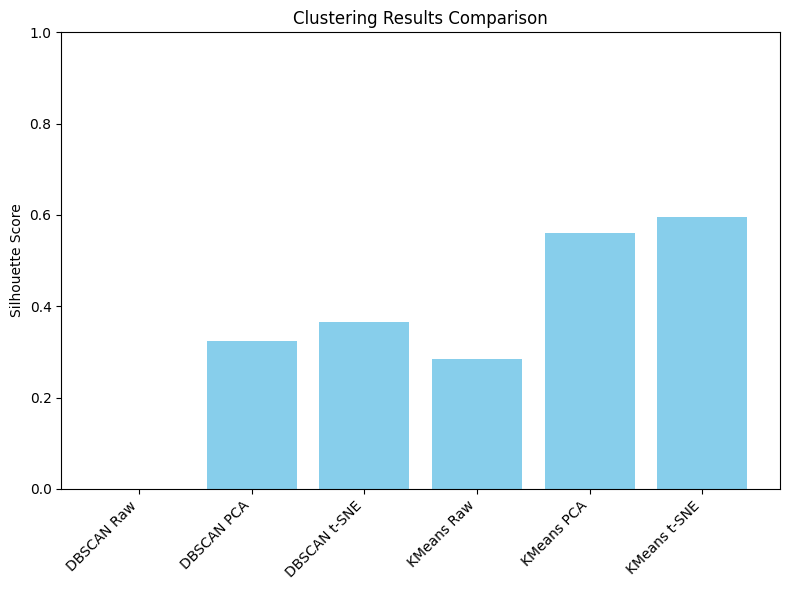

In [114]:
def plot_score_summary(score_dict):
    """
    Plots a bar chart of Silhouette Scores from a dictionary like:
    """
    labels = list(score_dict.keys())
    scores = list(score_dict.values())

    plt.figure(figsize=(8,6))
    plt.bar(labels, scores, color='skyblue')
    plt.xticks(rotation=45, ha='right')
    plt.ylabel('Silhouette Score')
    plt.title('Clustering Results Comparison')
    plt.ylim(0, 1)
    plt.tight_layout()
    plt.show()

# Create a dictionary for the scores
score_dict = {
    # DBSCAN
    'DBSCAN Raw': 0, # I hardcoded it to 0 because it always seemed to have a single cluster on WINE
    'DBSCAN PCA': pca_score,
    'DBSCAN t-SNE': tsne_score_optimized,
    # KMeans
    'KMeans Raw': kmeans_raw_score,
    'KMeans PCA': kmeans_pca_score,
    'KMeans t-SNE': kmeans_tsne_score
}

plot_score_summary(score_dict)